In [25]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import pdb
import copy
from scipy import sparse
import anndata
import cerberus
import plotly.io as pio
from pandarallel import pandarallel


p = os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))
sys.path.append(p)

from scripts.utils import *
from scripts.plotting import *

In [26]:
h5 = 'cerberus_annot.h5'
ab = '../talon/human_talon_abundance.tsv'
filt_ab = '../cerberus_filtered_abundance.tsv'
obs_col = 'sample'
min_tpm = 1
major_set = 'swan/isos_sample_gene_90.tsv'
mm_tissues = get_mouse_match_samples()
gene_subset = ['protein_coding']
annot_ver = 'v40_cerberus'
swan_file = '../swan/swan.p'

In [27]:
sg = swan.read(swan_file)

Read in graph from ../swan/swan.p


In [28]:
ca = cerberus.read('cerberus_annot_triplets.h5')

In [29]:
df = pd.DataFrame()
df['gid'] = []
df['source'] = []
df['sector'] = []
for source in ['obs_major', 'obs_det']:
    temp = ca.triplets.loc[ca.triplets.source == source]
    temp = assign_gisx_sector(temp)
    # temp = temp[['gid', 'source', 'sector']]
    df = df.merge(temp, how='outer', on='gid', suffixes=('', '_{}'.format(source)))

df.drop(['source', 'sector'], axis=1, inplace=True)

In [30]:
df.head()

source_obs_major              gid  n_tss  n_tes  n_ic  n_iso  \
0        obs_major  ENSG00000000003    1.0    5.0   5.0   12.0   
1        obs_major  ENSG00000000005    1.0    1.0   1.0    1.0   
2        obs_major  ENSG00000000419    2.0    3.0   8.0   10.0   
3        obs_major  ENSG00000000457    1.0    3.0   3.0    5.0   
4        obs_major  ENSG00000000460    2.0    4.0   6.0   10.0   

   splicing_ratio  tss_ratio  tes_ratio  spl_ratio  ... n_ic_obs_det  \
0        1.666667   0.130435   0.652174   0.217391  ...          9.0   
1        1.000000   0.333333   0.333333   0.333333  ...          1.0   
2        3.200000   0.243902   0.365854   0.390244  ...          9.0   
3        1.500000   0.181818   0.545455   0.272727  ...          5.0   
4        2.000000   0.250000   0.500000   0.250000  ...          7.0   

  n_iso_obs_det  splicing_ratio_obs_det tss_ratio_obs_det tes_ratio_obs_det  \
0          28.0                2.571429          0.104478          0.626866   
1           1.0                1.000000          0.333333          0.333333   
2          15.0                3.000000          0.222222          0.444444   
3           7.0                1.428571          0.355932          0.474576   
4          15.0                2.000000          0.333333          0.444444   

   spl_ratio_obs_det  gname_obs_det  sample_obs_det  gene_tpm_obs_det  \
0           0.268657         TSPAN6             NaN               NaN   
1           0.333333           TNMD             NaN               NaN   
2           0.333333           DPM1             NaN               NaN   
3           0.169492          SCYL3             NaN               NaN   
4           0.222222       C1orf112             NaN               NaN   

   sector_obs_det  
0             tes  
1          simple  
2           mixed  
3           mixed  
4           mixed  

[5 rows x 27 columns]

In [31]:
# compute dist b/w obs_det and obs_major
pandarallel.initialize(nb_workers=8, verbose=1)
df['dist'] = df.parallel_apply(simplex_dist,
                               args=('', '_obs_det'),
                               axis=1)
df.dist = df.dist.fillna(0)

In [32]:
df.head()

source_obs_major              gid  n_tss  n_tes  n_ic  n_iso  \
0        obs_major  ENSG00000000003    1.0    5.0   5.0   12.0   
1        obs_major  ENSG00000000005    1.0    1.0   1.0    1.0   
2        obs_major  ENSG00000000419    2.0    3.0   8.0   10.0   
3        obs_major  ENSG00000000457    1.0    3.0   3.0    5.0   
4        obs_major  ENSG00000000460    2.0    4.0   6.0   10.0   

   splicing_ratio  tss_ratio  tes_ratio  spl_ratio  ... n_iso_obs_det  \
0        1.666667   0.130435   0.652174   0.217391  ...          28.0   
1        1.000000   0.333333   0.333333   0.333333  ...           1.0   
2        3.200000   0.243902   0.365854   0.390244  ...          15.0   
3        1.500000   0.181818   0.545455   0.272727  ...           7.0   
4        2.000000   0.250000   0.500000   0.250000  ...          15.0   

  splicing_ratio_obs_det  tss_ratio_obs_det tes_ratio_obs_det  \
0               2.571429           0.104478          0.626866   
1               1.000000           0.333333          0.333333   
2               3.000000           0.222222          0.444444   
3               1.428571           0.355932          0.474576   
4               2.000000           0.333333          0.444444   

  spl_ratio_obs_det  gname_obs_det  sample_obs_det  gene_tpm_obs_det  \
0          0.268657         TSPAN6             NaN               NaN   
1          0.333333           TNMD             NaN               NaN   
2          0.333333           DPM1             NaN               NaN   
3          0.169492          SCYL3             NaN               NaN   
4          0.222222       C1orf112             NaN               NaN   

   sector_obs_det      dist  
0             tes  0.046883  
1          simple  0.000000  
2           mixed  0.057280  
3           mixed  0.147188  
4           mixed  0.064905  

[5 rows x 28 columns]

In [33]:
# # temp fix until I make sure I'm only considering isoforms >= 1 tpm in major set
# df = df.loc[~df.source_obs_det.isnull()]

In [34]:
# df.loc[df.source_obs_det.isnull()]

In [35]:
# check to see where nan source_obs_dets are coming from
# df = pd.read_csv(filt_ab, sep='\t')
# df, tids = get_tpm_table(df,
#                how='iso',
#                min_tpm=0)
# df.reset_index(inplace=True)
# beep = df.loc[df.annot_transcript_id.str.contains('ENSG00000285978')].set_index('annot_transcript_id').transpose()
# beep.loc[beep['ENSG00000285978[1,1,1]']>0]

In [36]:
# limit to gene subset
if gene_subset:
    gene_df, _, _ = get_gtf_info(how='gene', ver=annot_ver)
    gene_df['gid'] = cerberus.get_stable_gid(gene_df, 'gid')
    df = df.merge(gene_df[['gid', 'biotype_category']],
                      how='left', on='gid')
    df = df.loc[df.biotype_category.isin(gene_subset)]
    df.drop('biotype_category', axis=1, inplace=True)

In [37]:
df.head()

source_obs_major              gid  n_tss  n_tes  n_ic  n_iso  \
0        obs_major  ENSG00000000003    1.0    5.0   5.0   12.0   
1        obs_major  ENSG00000000005    1.0    1.0   1.0    1.0   
2        obs_major  ENSG00000000419    2.0    3.0   8.0   10.0   
3        obs_major  ENSG00000000457    1.0    3.0   3.0    5.0   
4        obs_major  ENSG00000000460    2.0    4.0   6.0   10.0   

   splicing_ratio  tss_ratio  tes_ratio  spl_ratio  ... n_iso_obs_det  \
0        1.666667   0.130435   0.652174   0.217391  ...          28.0   
1        1.000000   0.333333   0.333333   0.333333  ...           1.0   
2        3.200000   0.243902   0.365854   0.390244  ...          15.0   
3        1.500000   0.181818   0.545455   0.272727  ...           7.0   
4        2.000000   0.250000   0.500000   0.250000  ...          15.0   

  splicing_ratio_obs_det  tss_ratio_obs_det tes_ratio_obs_det  \
0               2.571429           0.104478          0.626866   
1               1.000000           0.333333          0.333333   
2               3.000000           0.222222          0.444444   
3               1.428571           0.355932          0.474576   
4               2.000000           0.333333          0.444444   

  spl_ratio_obs_det  gname_obs_det  sample_obs_det  gene_tpm_obs_det  \
0          0.268657         TSPAN6             NaN               NaN   
1          0.333333           TNMD             NaN               NaN   
2          0.333333           DPM1             NaN               NaN   
3          0.169492          SCYL3             NaN               NaN   
4          0.222222       C1orf112             NaN               NaN   

   sector_obs_det      dist  
0             tes  0.046883  
1          simple  0.000000  
2           mixed  0.057280  
3           mixed  0.147188  
4           mixed  0.064905  

[5 rows x 28 columns]

In [38]:
# save
df.to_csv('obs_v_obs_major_sectors.tsv', sep='\t', index=False)

In [ ]:
df.drop(['source_obs_major', 'source_obs_det'], axis=1, inplace=True)
df = df.groupby(['sector_obs_major', 'sector_obs_det']).count().reset_index()

## Sankey plot

{'tss': '#56B4E9', 'splicing': '#CC79A7', 'tes': '#E69F00', 'simple': '#000000', 'mixed': '#b7b7b7'}


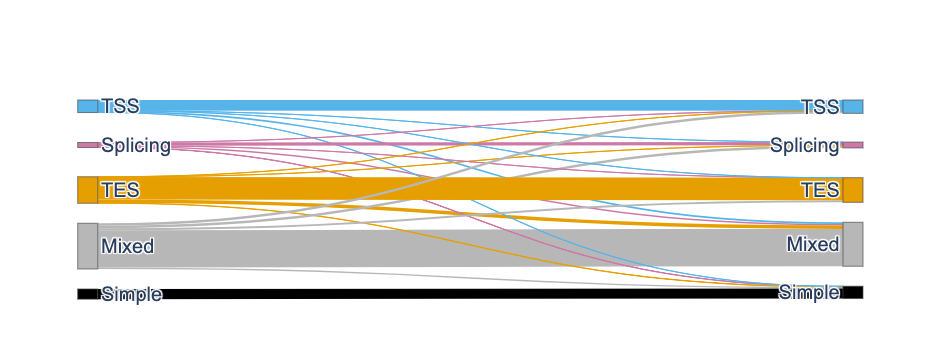

In [12]:
ofile = 'figures/obs_det_obs_major_sankey.pdf'
fig = plot_sankey(df,
                  source='sector_obs_det',
                  sink='sector_obs_major',
                  counts='gid',
                  color='sector',
                  title='')
h = 700
w = 1.8792590838529746*h
pio.write_image(fig, ofile, width=w, height=h)

In [13]:
# what overall % are the same?
df['same'] = df.sector_obs_major == df.sector_obs_det
temp = df[['gid', 'same']].groupby('same').sum().reset_index()
n = temp.loc[temp.same == True, 'gid'].values[0]/temp.gid.sum()
print('{:.2f}% of protein coding genes are in the same sector b/w obs and obs major'.format(n*100))

83.91% of protein coding genes are in the same sector b/w obs and obs major


In [14]:
total_det = df[['sector_obs_det', 'gid']].groupby('sector_obs_det').sum().reset_index()
total_det.rename({'gid': 'total'}, axis=1, inplace=True)
total_det.head()

sector_obs_det  total
0          mixed   8014
1         simple   1783
2       splicing    888
3            tes   4641
4            tss   2197

In [15]:
df[['sector_obs_major', 'gid']].groupby('sector_obs_major').sum().reset_index()


sector_obs_major   gid
0            mixed  7698
1           simple  2162
2         splicing  1022
3              tes  4306
4              tss  2335

## What % of genes retain their sectors?

In [17]:
n = df.gid.sum()
n_num = df.loc[df.same == True, 'gid'].sum()
print('{:.2f}% of protein-coding genes ({}/{}) stay in the same sector between obs. and obs. major'.format((n_num/n)*100,n_num,n))

83.91% of protein-coding genes (14703/17523) stay in the same sector between obs. and obs. major


In [15]:
### df = df.merge(total_det, how='left', on='sector_obs_det')

In [38]:
# df['perc'] = (df['gid']/df['total'])*100

In [ ]:
df.loc[df.sector_obs_major==df.sector_obs_det]

{'tss': '#56B4E9', 'splicing': '#CC79A7', 'tes': '#E69F00', 'simple': '#000000', 'mixed': '#b7b7b7'}


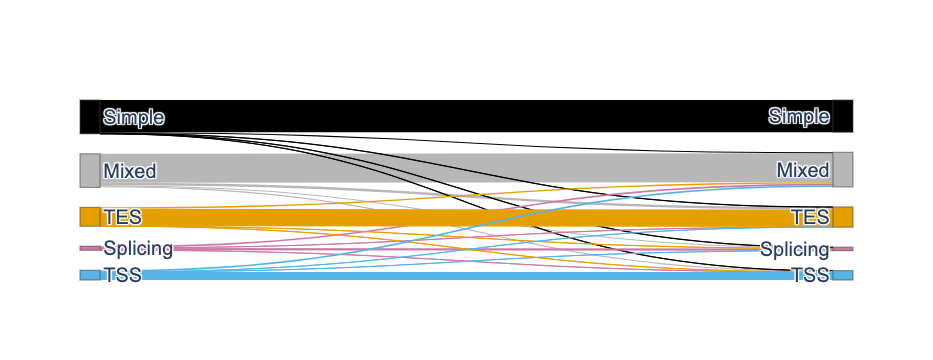

In [20]:
# what about the other way around?

ofile = 'figures/obs_major_obs_det_sankey.pdf'
fig = plot_sankey(df,
                  source='sector_obs_major',
                  sink='sector_obs_det',
                  counts='gid',
                  color='sector',
                  title='')
h = 700
w = 1.8792590838529746*h
pio.write_image(fig, ofile, width=w, height=h)

## What genes hone in on a specific behavior? ie mixed -> splicing, tss, tes

In [39]:
df = pd.read_csv('obs_v_obs_major_sectors.tsv', sep='\t')

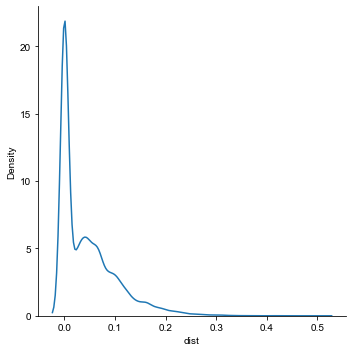

In [40]:
sns.displot(df, x='dist', kind='kde')

In [41]:
df = df.loc[df.sector_obs_det == 'mixed'].copy(deep=True)
df = df.loc[df.sector_obs_major.isin(['tss', 'tes', 'splicing'])]

In [42]:
# add gene info
gene_df, _, _ = get_gtf_info(how='gene', ver='v40_cerberus')
gene_df['gid_stable'] = cerberus.get_stable_gid(gene_df, col='gid')
gene_df = gene_df[['gid_stable', 'tf']]
df = df.merge(gene_df, how='left', left_on='gid', right_on='gid_stable')

In [43]:
df.sort_values(by='dist', ascending=False)[['gname', 'sector_obs_det', 'sector_obs_major', 'dist']].head(20)

gname sector_obs_det sector_obs_major      dist
744     EIF4A2          mixed         splicing  0.504175
360       CD46          mixed         splicing  0.405646
923      MAT2A          mixed         splicing  0.373265
271   CDK5RAP3          mixed         splicing  0.365663
571       PREB          mixed         splicing  0.357590
714       NEK7          mixed         splicing  0.351119
822     ANKZF1          mixed         splicing  0.337898
755     CNOT11          mixed         splicing  0.333354
716      THYN1          mixed         splicing  0.326052
432     HNRNPR          mixed         splicing  0.324917
352      SRSF4          mixed         splicing  0.321997
626      DUS3L          mixed         splicing  0.315905
1176     IFRD2          mixed         splicing  0.313426
1          BAD          mixed         splicing  0.311159
28        NCDN          mixed         splicing  0.308091
153     HNRNPM          mixed         splicing  0.305842
1197     PRAF2          mixed         splicing  0.303685
672     TBC1D7          mixed         splicing  0.303256
173       LGMN          mixed         splicing  0.301681
619     WDR45B          mixed         splicing  0.300942

In [44]:
df.loc[df.tf==True].sort_values(by='dist', ascending=False)[['gname', 'sector_obs_det', 'sector_obs_major', 'dist']].head(20)

gname sector_obs_det sector_obs_major      dist
474    NR1H2          mixed         splicing  0.258974
902     E4F1          mixed         splicing  0.249271
1079    HSF1          mixed         splicing  0.243269
107   ZNF671          mixed         splicing  0.230828
794    FOXH1          mixed              tes  0.205586
134   ZNF302          mixed         splicing  0.194774
637     RORC          mixed              tes  0.176682
80    SREBF1          mixed              tss  0.175263
508    ARNTL          mixed         splicing  0.174723
1085    IRF7          mixed         splicing  0.167852
943    ZNF32          mixed         splicing  0.158722
162     XBP1          mixed              tss  0.157358
418    CTCFL          mixed              tss  0.152686
465   ZNF337          mixed         splicing  0.133511
1139  ZNF627          mixed         splicing  0.122487
773     ISL2          mixed         splicing  0.121569
851    NFIL3          mixed              tss  0.119380
910     IRF2          mixed              tss  0.116754
1119   ZNF79          mixed         splicing  0.111439
56    RFXANK          mixed         splicing  0.106880

In [45]:
def plot_simplex_here(ca, gene, opref='figures/'):
    # det
    c_dict, order = get_biosample_colors()
    c_dict[np.nan] = 'k'
    mmap = {'v40': '*', 'v29': 'x', 'obs_det': '^', 'cerberus': '2', 'sample_det_centroid': 's'} 
    subset = {'source': ['v40', 'obs_det', 'sample_det']}
    fname=f'{opref}/simplex_{gene.lower()}_det.pdf'
    df = ca.plot_simplex(top='splicing_ratio', 
                gene=gene,
                hue='sample',
                cmap=c_dict,
                density=True,
                density_scale=50,
                density_cmap='Purples',
                size='gene_tpm', 
                log_size=True,
                sectors=True,
                marker_style='source',
                mmap=mmap,
                legend=False,
                jitter=True,
                subset=subset,
                size_scale=0.5,
                fname=fname)
    
    
    mmap = {'v40': '*', 'v29': 'x', 'obs_major': '^', 'cerberus': '2', 'sample_det_centroid': 's'} 
    subset = {'source': ['v40', 'obs_major', 'sample_major']}
    fname=f'{opref}/simplex_{gene.lower()}_major.pdf'
    df = ca.plot_simplex(top='splicing_ratio', 
                gene=gene,
                hue='sample',
                cmap=c_dict,
                density=True,
                density_scale=50,
                density_cmap='Purples',
                size='gene_tpm', 
                log_size=True,
                sectors=True,
                marker_style='source',
                mmap=mmap,
                legend=False,
                jitter=True,
                subset=subset,
                size_scale=0.5,
                fname=fname)

In [ ]:
# znfs

In [49]:
ca.triplets.loc[(ca.triplets.gname=='ZNF671')&(ca.triplets.source.isin(['obs_det', 'obs_major']))]

source              gid  n_tss  n_tes  n_ic  n_iso  splicing_ratio  \
1574    obs_det  ENSG00000083814    1.0    3.0   4.0    5.0             2.0   
1574  obs_major  ENSG00000083814    1.0    1.0   3.0    3.0             3.0   

      tss_ratio  tes_ratio  spl_ratio   gname sample  gene_tpm  
1574   0.166667        0.5   0.333333  ZNF671    NaN       NaN  
1574   0.200000        0.2   0.600000  ZNF671    NaN       NaN

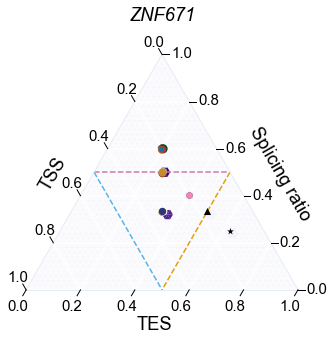

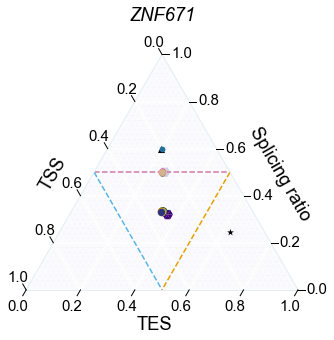

In [46]:
plot_simplex_here(ca, 'ZNF671')

source              gid  n_tss  n_tes  n_ic  n_iso  splicing_ratio  \
1801    obs_det  ENSG00000089335    2.0    6.0  22.0   35.0             5.5   
1801  obs_major  ENSG00000089335    1.0    3.0  17.0   23.0             8.5   

      tss_ratio  tes_ratio  spl_ratio   gname sample  gene_tpm  
1801   0.148148   0.444444   0.407407  ZNF302    NaN       NaN  
1801   0.080000   0.240000   0.680000  ZNF302    NaN       NaN

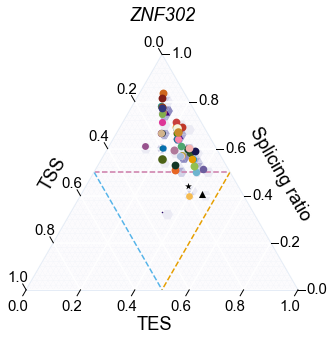

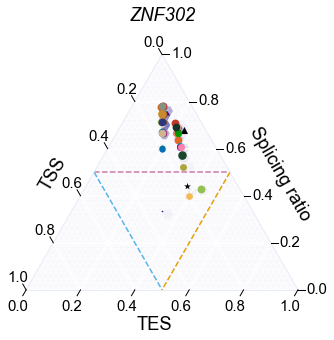

In [57]:
gname = 'ZNF302'
plot_simplex_here(ca, gname)
ca.triplets.loc[(ca.triplets.gname==gname)&(ca.triplets.source.isin(['obs_det', 'obs_major']))]

source              gid  n_tss  n_tes  n_ic  n_iso  splicing_ratio  \
11958    obs_det  ENSG00000169740    3.0    2.0   8.0    9.0        3.200000   
11958  obs_major  ENSG00000169740    2.0    1.0   7.0    8.0        4.666667   

       tss_ratio  tes_ratio  spl_ratio  gname sample  gene_tpm  
11958   0.365854   0.243902   0.390244  ZNF32    NaN       NaN  
11958   0.260870   0.130435   0.608696  ZNF32    NaN       NaN

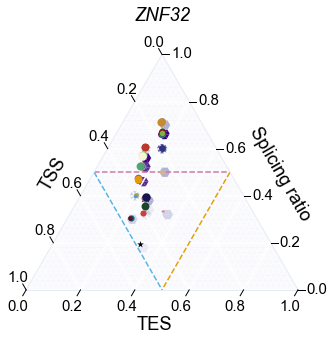

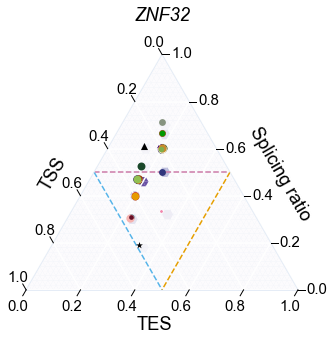

In [56]:
gname = 'ZNF32'
plot_simplex_here(ca, gname)
ca.triplets.loc[(ca.triplets.gname==gname)&(ca.triplets.source.isin(['obs_det', 'obs_major']))]

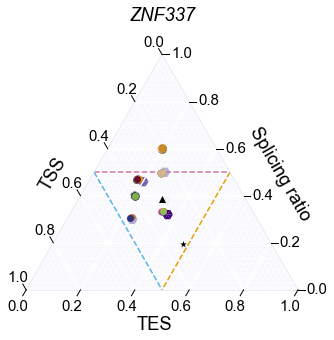

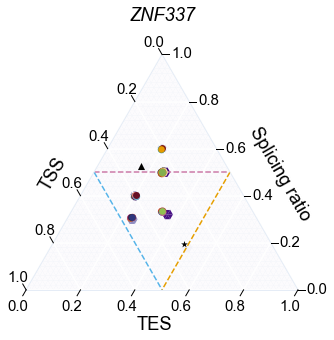

In [53]:
gname = 'ZNF337'
plot_simplex_here(ca, gname)
ca.triplets.loc[(ca.triplets.gname==gname)&(ca.triplets.source.isin(['obs_det', 'obs_major']))]


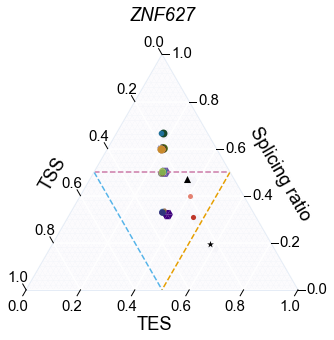

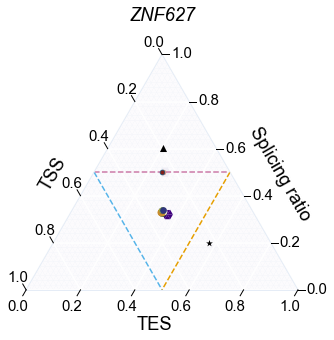

In [54]:
gname = 'ZNF627'
plot_simplex_here(ca, gname)
ca.triplets.loc[(ca.triplets.gname==gname)&(ca.triplets.source.isin(['obs_det', 'obs_major']))]


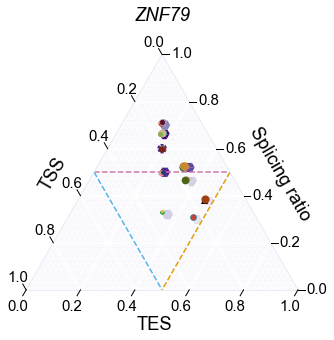

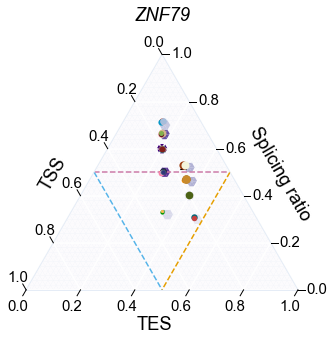

In [55]:
gname = 'ZNF79'
ca.triplets.loc[(ca.triplets.gname==gname)&(ca.triplets.source.isin(['obs_det', 'obs_major']))]
plot_simplex_here(ca, gname)

In [58]:
# density for znfs in obs vs obs major

In [61]:
# add biotype category
gene_df, _, _ = get_gtf_info(how='gene', ver='v40_cerberus')
gene_df['gid'] = cerberus.get_stable_gid(gene_df, 'gid')
gene_df = gene_df[['gid', 'tf']]
ca.triplets = ca.triplets.merge(gene_df, how='left', on='gid')

In [62]:
ca.triplets = ca.triplets.loc[(ca.triplets.gname.str.contains('ZNF'))&(ca.triplets.tf==True)]


source              gid  n_tss  n_tes  n_ic  n_iso  splicing_ratio  \
105    v40  ENSG00000005801    4.0   14.0  30.0   31.0        3.333333   
128    v40  ENSG00000006194    5.0    6.0   8.0    8.0        1.454545   
386    v40  ENSG00000018869    1.0    4.0   4.0    6.0        1.600000   
760    v40  ENSG00000056277    1.0    2.0   2.0    2.0        1.333333   
841    v40  ENSG00000062370    2.0    4.0   6.0    6.0        2.000000   

     tss_ratio  tes_ratio  spl_ratio    gname sample  gene_tpm    tf  
105   0.187500   0.656250   0.156250   ZNF195    NaN       NaN  True  
128   0.401460   0.481752   0.116788   ZNF263    NaN       NaN  True  
386   0.151515   0.606061   0.242424   ZNF582    NaN       NaN  True  
760   0.230769   0.461538   0.307692  ZNF280C    NaN       NaN  True  
841   0.250000   0.500000   0.250000   ZNF112    NaN       NaN  True

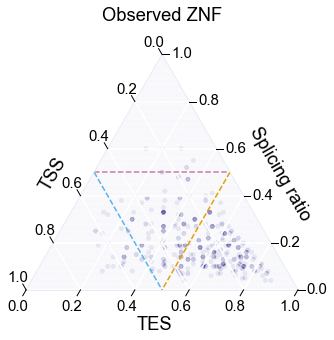

In [66]:
subset = {'source': ['obs_det']}
temp = ca.plot_simplex(top='splicing_ratio',
            subset=subset,
            density=True,
            density_scale=100,
            density_cmap='Purples',
            log_density=True,
            sectors=True,
            scatter=False,
            legend=False,
            title='Observed ZNF',
            size_scale=0.5,
            density_cbar=False,
            fname='figures/simplex_density_obs_det_znf.pdf')

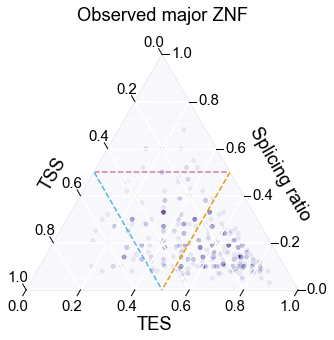

In [67]:
subset = {'source': ['obs_major']}
temp = ca.plot_simplex(top='splicing_ratio',
            subset=subset,
            density=True,
            density_scale=100,
            density_cmap='Purples',
            log_density=True,
            sectors=True,
            scatter=False,
            legend=False,
            title='Observed major ZNF',
            size_scale=0.5,
            density_cbar=False,
            fname='figures/simplex_density_obs_major_znf.pdf')

In [ ]:
# others

In [ ]:
ca = cerberus.read(c_annot)

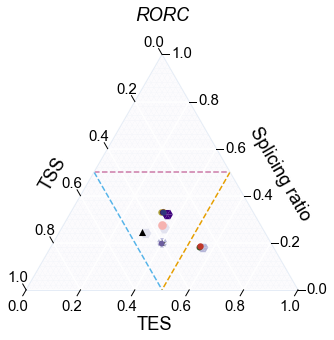

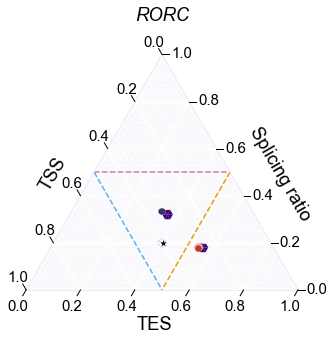

In [17]:
plot_simplex_here(ca, 'RORC')

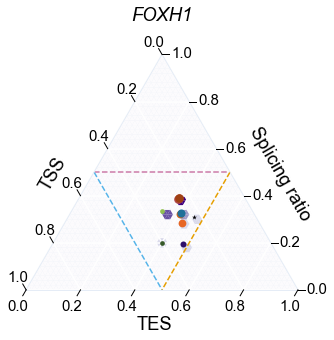

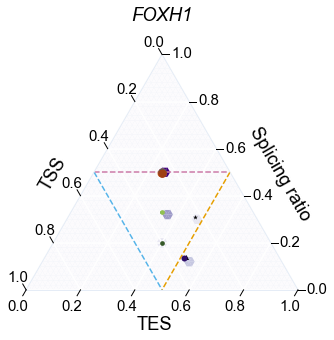

In [88]:
plot_simplex_here(ca, 'FOXH1')

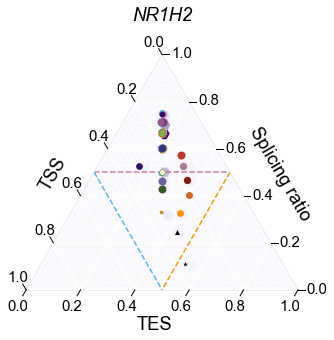

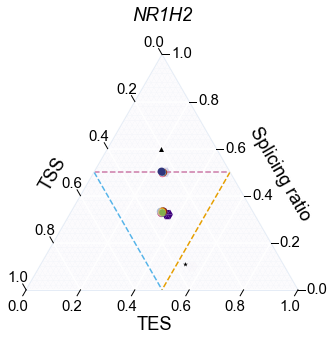

In [89]:
plot_simplex_here(ca, 'NR1H2')

In [19]:
ca.triplets.loc[(ca.triplets.gname=='E4F1')&(ca.triplets.source.isin(['obs_det', 'obs_major']))]

source              gid  n_tss  n_tes  n_ic  n_iso  splicing_ratio  \
11578    obs_det  ENSG00000167967    4.0    3.0  13.0   13.0        3.714286   
11578  obs_major  ENSG00000167967    2.0    1.0  10.0   10.0        6.666667   

       tss_ratio  tes_ratio  spl_ratio gname sample  gene_tpm  
11578   0.373333   0.280000   0.346667  E4F1    NaN       NaN  
11578   0.206897   0.103448   0.689655  E4F1    NaN       NaN

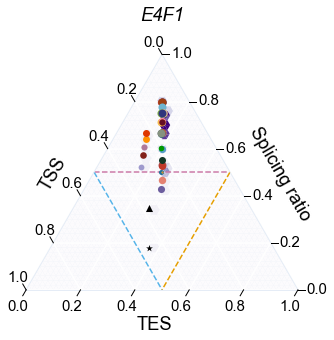

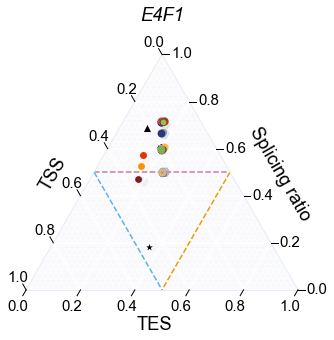

In [20]:
plot_simplex_here(ca, 'E4F1', opref='/Users/fairliereese/Documents/programming/mortazavi_lab/documents/rnawg/fig4/')

Calculating iso TPM values
Subsetting for polya genes


/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1817: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[tpm_col] = (df[d]*1000000)/df[total_col]
/Users/fairliereese/Documents/programming/mortazavi_lab/data/rnawg/scripts/utils.py:1816: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[total_col] = df[d].sum()


Enforcing minimum TPM
Total # isos detected: 234040
# isos >= 1 tpm: 212911
Applying gene type and novelty subset
Number of isos reported: 209476
Found 50 total samples
small text size: 20.3
big text size: 17.571194762684122


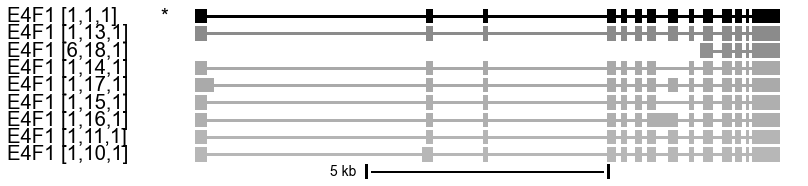

In [12]:
gene = 'E4F1'
obs_col = 'sample'
obs_condition = 'a673'
ax, tpm_df = plot_browser_isos(ca, sg, gene,
                                         obs_col, obs_condition,
                                         filt_ab, major_set,
                                         h_space=0.24,
                                         h=0.2, ref_source='v40')

Calculating iso TPM values
Subsetting for polya genes
Enforcing minimum TPM
Total # isos detected: 234040
# isos >= 1 tpm: 212911
Applying gene type and novelty subset
Number of isos reported: 209476
Found 50 total samples
small text size: 20.3
big text size: 17.571194762684122


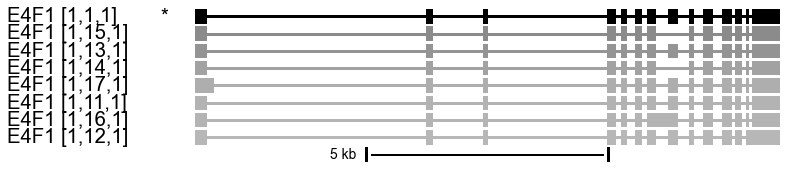

In [13]:
gene = 'E4F1'
obs_col = 'sample'
obs_condition = 'h9'
ax, tpm_df = plot_browser_isos(ca, sg, gene,
                                         obs_col, obs_condition,
                                         filt_ab, major_set,
                                         h_space=0.24,
                                         h=0.2, ref_source='v40')

In [15]:
ca.triplets.loc[(ca.triplets.gname=='E4F1')&(ca.triplets.source.isin(['obs_major', 'obs_det']))]

source              gid  n_tss  n_tes  n_ic  n_iso  splicing_ratio  \
11578    obs_det  ENSG00000167967    4.0    3.0  13.0   13.0        3.714286   
11578  obs_major  ENSG00000167967    2.0    1.0  10.0   10.0        6.666667   

       tss_ratio  tes_ratio  spl_ratio gname sample  gene_tpm  
11578   0.373333   0.280000   0.346667  E4F1    NaN       NaN  
11578   0.206897   0.103448   0.689655  E4F1    NaN       NaN

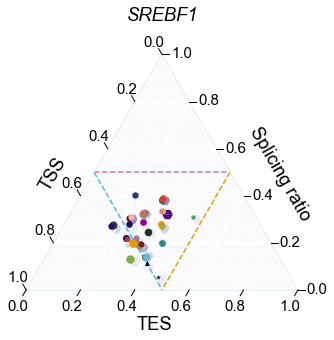

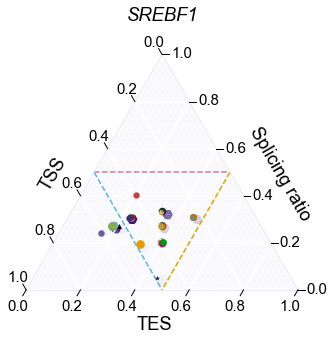

In [97]:
plot_simplex_here(ca, 'SREBF1')